# Homework 4 - RNNs
10/21/2022
Author: Matt Uryga




## Task 1

### Part 1 - RNN

#### Exploratory Data Analysis
I chose to use a temperature time series dataset.  It consists of hourly air temperatures from various places in the USA.  For this assignment, I am only going to be using the data from one city (Minneapolis).

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
# read in data
temps = pd.read_csv('temperature.csv', parse_dates=['datetime'])
temps = temps.set_index('datetime')

# print shape
print(f'Dataset shape: {temps.shape}')

Dataset shape: (45253, 36)


There are 36 locations with 45,253 temperature records each.

In [37]:
# extract only one city's worth of temp data
temps = temps[['Minneapolis']]

# print stats on dataset
print(temps.describe())

        Minneapolis
count  45240.000000
mean     280.700489
std       12.774979
min      242.336667
25%      271.790000
50%      281.639000
75%      291.310000
max      308.240000


Temperatures are in Kelvin, we can convert to Celsius

In [38]:
temps = temps - 273.15

Plot temp over time

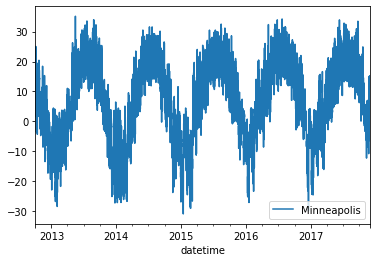

<Figure size 432x288 with 0 Axes>

In [39]:
temps.plot()
plt.show()
plt.clf()

Plot temp over time in a smaller window

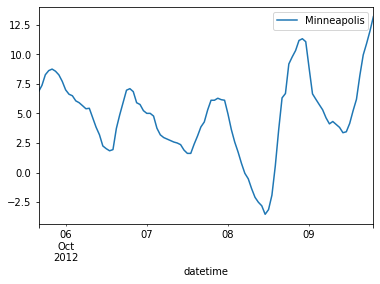

<Figure size 432x288 with 0 Axes>

In [40]:
temps[100:200].plot()
plt.show()
plt.clf()

On long timescales, the temperature changes are due to seasons.  There is approx. a -30 to 30 degree range between seasons.
On short timescales, the changes in temperature is due to time of day.

In [41]:
# extract temps into np array
temps = temps.to_numpy()[1:].T[0].astype(np.float32)
# remove any nans
temps = temps[~np.isnan(temps)]

In [42]:
# check shape of temps
print(f'{temps.shape = }')

temps.shape = (45240,)


In [43]:
# split into train/validation/test
n = len(temps)
train_temps = temps[:int(0.8*n)]
valid_temps = temps[int(0.8*n):int(0.9*n)]
test_temps = temps[int(0.9*n):]

#### Model and Dataset

In [44]:
# constants
num_workers = 8
batch_size = 1024
num_epochs = 100
learning_rate = 0.001
window = 64
progress_bar = True
# get device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


In [45]:
class Temp_Dataset(Dataset):
	def __init__(self, temps, window):
		super().__init__()
		self.temps = temps
		self.window = window

	def __getitem__(self, x):
		# return time series and next value
		return self.temps[x:x + self.window], self.temps[x + self.window]

	def __len__(self):
		return len(self.temps) - self.window

#### Model Structure
Note that the structure of the RNN is identical for the LSTM and the GRU models as well.

The model begins with a 2-layer stacked RNN, followed by a flattening so that the output can be fed into a simple feed forward network.  The FFN component consists of 2 linear layers with a dropout inbetween.  There is no activation function being used in the model because the labels lie within the range of all real numbers (approx between -30 and 30), and using sigmoid/tanh would clip the output, and ReLu would impact the effectiveness in predicting negative temperatures.

The performance metric chosen is mean squared error.  The model is attempting to predict a value, and mean squared error allows the model to effectively determine poor predictions, and the worse a prediction is, the worse the loss will be.

In [46]:
class Model(nn.Module):
	def __init__(self, window, hidden_dim, out_dim, nn_type):
		super().__init__()

		# flatten function
		self.flatten = nn.Flatten()

		# select specified RNN
		if nn_type == 'RNN':
			self.rnn = nn.RNN(input_size = window, hidden_size = hidden_dim, num_layers = 2, batch_first = True, dropout = 0.5)
		elif nn_type == 'LSTM':
			self.rnn = nn.LSTM(input_size = window, hidden_size = hidden_dim, num_layers = 2, batch_first = True, dropout = 0.5)
		elif nn_type == 'GRU':
			self.rnn = nn.GRU(input_size = window, hidden_size = hidden_dim, num_layers = 2, batch_first = True, dropout = 0.5)

		self.fc1 = nn.Linear(hidden_dim, hidden_dim)
		self.drop = nn.Dropout(0.5)
		self.fc2 = nn.Linear(hidden_dim, out_dim)

	def forward(self, x):
		out, (hn, cn) = self.rnn(x)
		x = self.flatten(out)
		x = self.fc1(x)
		x = self.drop(x)
		x = self.fc2(x)
		return x

In [47]:
# create datasets
train_dataset = Temp_Dataset(train_temps, window)
valid_dataset = Temp_Dataset(valid_temps, window)
test_dataset = Temp_Dataset(test_temps, window)

In [48]:
# create dataloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

In [49]:
# initalize models
RNN_model = Model(window, 32, 1, 'RNN')
RNN_model = RNN_model.to(device)

LSTM_model = Model(window, 32, 1, 'LSTM')
LSTM_model = LSTM_model.to(device)

GRU_model = Model(window, 32, 1, 'GRU')
GRU_model = GRU_model.to(device)

#### Training Function

In [50]:
def train(model, train_loader, valid_loader):
	# initialize optimizer
	optimizer = optim.Adam(model.parameters(), lr = learning_rate)

	# initialize loss function
	loss_func = nn.MSELoss()

	# prev_loss is used to store validation losses -> training is stopped
	# once validation loss is above a 5-epoch rolling mean
	prev_loss = []

	# iterate for specified number of epochs
	for epoch in range(num_epochs):
		model.train()
		sum_loss = 0
		for batch_idx, (temps, labels) in enumerate(tqdm(train_loader, disable = not progress_bar, desc = f'Epoch {epoch:02d}', ncols=60)):
			# send tensors to device
			temps, labels = temps.to(device), labels.to(device)

			# zero out gradients
			optimizer.zero_grad()

			# forward pass
			preds = model(temps.float()).T[0]

			# calculate loss
			loss = loss_func(preds, labels)
			sum_loss += loss.item()

			# backward pass
			loss.backward()

			# step optimizer
			optimizer.step()

		print(f'\tTrain loss =      {sum_loss/(batch_idx+1)/batch_size:.6f}')

		# validation loop
		model.eval()
		valid_loss = 0
		with torch.no_grad():
			for batch_idx, (temps, labels) in enumerate(valid_loader):
				# send tensors to device
				temps, labels = temps.to(device), labels.to(device)

				# forward pass
				preds = model(temps.float()).T[0]

				# calculate loss
				loss = loss_func(preds, labels)
				valid_loss += loss.item()

		# append current loss to prev_loss list
		prev_loss.append(valid_loss/(batch_idx+1)/batch_size)

		print(f'\tValidation loss = {valid_loss/(batch_idx+1)/batch_size:.6f}')

		# # if valid_loss exceedes the 5-epoch rolling sum, break from training
		# if valid_loss/(batch_idx+1)/batch_size > np.mean(prev_loss[-5:]):
		# 	break

	return model, prev_loss

#### Testing Function

In [51]:
def test(model, test_loader):
	loss_func = nn.MSELoss()

	sum_loss = 0
	model.eval()
	with torch.no_grad():
		for batch_idx, (temps, labels) in enumerate(tqdm(test_loader, disable = not progress_bar, desc = 'Testing', ncols=60)):
			# send tensors to device
			temps, labels = temps.to(device), labels.to(device)

			# forward pass
			preds = model(temps.float()).T[0]

			# calculate loss
			loss = loss_func(preds, labels)
			sum_loss += loss.item()

	print(f'Test loss: {sum_loss/(batch_idx+1)/batch_size:.6f}')
	return sum_loss

### RNN

In [52]:
RNN_model, RNN_losses = train(RNN_model, train_loader, valid_loader)
RNN_loss = test(RNN_model, test_loader)

Epoch 00: 100%|█████████████| 36/36 [00:01<00:00, 18.41it/s]


	Train loss =      0.180403
	Validation loss = 0.058238


Epoch 01: 100%|█████████████| 36/36 [00:01<00:00, 19.87it/s]


	Train loss =      0.092951
	Validation loss = 0.032560


Epoch 02: 100%|█████████████| 36/36 [00:01<00:00, 24.02it/s]


	Train loss =      0.050625
	Validation loss = 0.022400


Epoch 03: 100%|█████████████| 36/36 [00:01<00:00, 24.30it/s]


	Train loss =      0.035136
	Validation loss = 0.015432


Epoch 04: 100%|█████████████| 36/36 [00:01<00:00, 23.34it/s]


	Train loss =      0.028534
	Validation loss = 0.010815


Epoch 05: 100%|█████████████| 36/36 [00:01<00:00, 23.02it/s]


	Train loss =      0.025461
	Validation loss = 0.010207


Epoch 06: 100%|█████████████| 36/36 [00:02<00:00, 17.77it/s]


	Train loss =      0.024267
	Validation loss = 0.008147


Epoch 07: 100%|█████████████| 36/36 [00:01<00:00, 18.71it/s]


	Train loss =      0.023311
	Validation loss = 0.008004


Epoch 08: 100%|█████████████| 36/36 [00:01<00:00, 19.87it/s]


	Train loss =      0.022784
	Validation loss = 0.008520


Epoch 09: 100%|█████████████| 36/36 [00:02<00:00, 17.93it/s]


	Train loss =      0.022435
	Validation loss = 0.008341


Epoch 10: 100%|█████████████| 36/36 [00:01<00:00, 19.05it/s]


	Train loss =      0.021490
	Validation loss = 0.007108


Epoch 11: 100%|█████████████| 36/36 [00:01<00:00, 21.68it/s]


	Train loss =      0.020939
	Validation loss = 0.006544


Epoch 12: 100%|█████████████| 36/36 [00:01<00:00, 19.30it/s]


	Train loss =      0.019128
	Validation loss = 0.005920


Epoch 13: 100%|█████████████| 36/36 [00:01<00:00, 20.23it/s]


	Train loss =      0.018628
	Validation loss = 0.006445


Epoch 14: 100%|█████████████| 36/36 [00:01<00:00, 20.43it/s]


	Train loss =      0.017137
	Validation loss = 0.005240


Epoch 15: 100%|█████████████| 36/36 [00:01<00:00, 22.55it/s]


	Train loss =      0.016981
	Validation loss = 0.004592


Epoch 16: 100%|█████████████| 36/36 [00:01<00:00, 20.64it/s]


	Train loss =      0.017690
	Validation loss = 0.004710


Epoch 17: 100%|█████████████| 36/36 [00:01<00:00, 18.23it/s]


	Train loss =      0.018356
	Validation loss = 0.004819


Epoch 18: 100%|█████████████| 36/36 [00:01<00:00, 19.60it/s]


	Train loss =      0.017599
	Validation loss = 0.004921


Epoch 19: 100%|█████████████| 36/36 [00:01<00:00, 21.39it/s]


	Train loss =      0.019124
	Validation loss = 0.005353


Epoch 20: 100%|█████████████| 36/36 [00:01<00:00, 18.44it/s]


	Train loss =      0.018627
	Validation loss = 0.005547


Epoch 21: 100%|█████████████| 36/36 [00:02<00:00, 16.93it/s]


	Train loss =      0.016737
	Validation loss = 0.004311


Epoch 22: 100%|█████████████| 36/36 [00:01<00:00, 20.58it/s]


	Train loss =      0.016071
	Validation loss = 0.004214


Epoch 23: 100%|█████████████| 36/36 [00:02<00:00, 17.16it/s]


	Train loss =      0.015195
	Validation loss = 0.003871


Epoch 24: 100%|█████████████| 36/36 [00:01<00:00, 18.93it/s]


	Train loss =      0.016242
	Validation loss = 0.003897


Epoch 25: 100%|█████████████| 36/36 [00:02<00:00, 17.37it/s]


	Train loss =      0.016827
	Validation loss = 0.004238


Epoch 26: 100%|█████████████| 36/36 [00:01<00:00, 23.10it/s]


	Train loss =      0.016680
	Validation loss = 0.004109


Epoch 27: 100%|█████████████| 36/36 [00:01<00:00, 21.05it/s]


	Train loss =      0.014964
	Validation loss = 0.003597


Epoch 28: 100%|█████████████| 36/36 [00:01<00:00, 20.89it/s]


	Train loss =      0.014354
	Validation loss = 0.003625


Epoch 29: 100%|█████████████| 36/36 [00:01<00:00, 19.26it/s]


	Train loss =      0.013849
	Validation loss = 0.003360


Epoch 30: 100%|█████████████| 36/36 [00:01<00:00, 19.87it/s]


	Train loss =      0.013920
	Validation loss = 0.003527


Epoch 31: 100%|█████████████| 36/36 [00:01<00:00, 19.99it/s]


	Train loss =      0.013731
	Validation loss = 0.003621


Epoch 32: 100%|█████████████| 36/36 [00:02<00:00, 16.57it/s]


	Train loss =      0.014280
	Validation loss = 0.004127


Epoch 33: 100%|█████████████| 36/36 [00:01<00:00, 22.46it/s]


	Train loss =      0.014493
	Validation loss = 0.003447


Epoch 34: 100%|█████████████| 36/36 [00:01<00:00, 22.76it/s]


	Train loss =      0.014161
	Validation loss = 0.003298


Epoch 35: 100%|█████████████| 36/36 [00:01<00:00, 21.68it/s]


	Train loss =      0.014426
	Validation loss = 0.003397


Epoch 36: 100%|█████████████| 36/36 [00:01<00:00, 22.58it/s]


	Train loss =      0.013815
	Validation loss = 0.003141


Epoch 37: 100%|█████████████| 36/36 [00:01<00:00, 23.36it/s]


	Train loss =      0.014325
	Validation loss = 0.003273


Epoch 38: 100%|█████████████| 36/36 [00:01<00:00, 20.72it/s]


	Train loss =      0.013923
	Validation loss = 0.002839


Epoch 39: 100%|█████████████| 36/36 [00:01<00:00, 23.07it/s]


	Train loss =      0.013607
	Validation loss = 0.003019


Epoch 40: 100%|█████████████| 36/36 [00:01<00:00, 22.57it/s]


	Train loss =      0.013550
	Validation loss = 0.002934


Epoch 41: 100%|█████████████| 36/36 [00:01<00:00, 20.06it/s]


	Train loss =      0.013208
	Validation loss = 0.003553


Epoch 42: 100%|█████████████| 36/36 [00:01<00:00, 20.80it/s]


	Train loss =      0.013448
	Validation loss = 0.003442


Epoch 43: 100%|█████████████| 36/36 [00:02<00:00, 15.36it/s]


	Train loss =      0.013582
	Validation loss = 0.002823


Epoch 44: 100%|█████████████| 36/36 [00:01<00:00, 20.49it/s]


	Train loss =      0.013486
	Validation loss = 0.002795


Epoch 45: 100%|█████████████| 36/36 [00:01<00:00, 20.69it/s]


	Train loss =      0.012794
	Validation loss = 0.003185


Epoch 46: 100%|█████████████| 36/36 [00:01<00:00, 18.54it/s]


	Train loss =      0.012917
	Validation loss = 0.002657


Epoch 47: 100%|█████████████| 36/36 [00:01<00:00, 20.05it/s]


	Train loss =      0.012849
	Validation loss = 0.002768


Epoch 48: 100%|█████████████| 36/36 [00:02<00:00, 17.59it/s]


	Train loss =      0.012817
	Validation loss = 0.003208


Epoch 49: 100%|█████████████| 36/36 [00:01<00:00, 19.81it/s]


	Train loss =      0.013890
	Validation loss = 0.002907


Epoch 50: 100%|█████████████| 36/36 [00:01<00:00, 20.18it/s]


	Train loss =      0.013561
	Validation loss = 0.002562


Epoch 51: 100%|█████████████| 36/36 [00:01<00:00, 19.42it/s]


	Train loss =      0.013551
	Validation loss = 0.002856


Epoch 52: 100%|█████████████| 36/36 [00:02<00:00, 17.97it/s]


	Train loss =      0.012663
	Validation loss = 0.002649


Epoch 53: 100%|█████████████| 36/36 [00:01<00:00, 18.96it/s]


	Train loss =      0.013006
	Validation loss = 0.002466


Epoch 54: 100%|█████████████| 36/36 [00:01<00:00, 21.90it/s]


	Train loss =      0.012300
	Validation loss = 0.002793


Epoch 55: 100%|█████████████| 36/36 [00:01<00:00, 19.59it/s]


	Train loss =      0.012451
	Validation loss = 0.002615


Epoch 56: 100%|█████████████| 36/36 [00:01<00:00, 20.10it/s]


	Train loss =      0.012404
	Validation loss = 0.002617


Epoch 57: 100%|█████████████| 36/36 [00:01<00:00, 21.80it/s]


	Train loss =      0.012253
	Validation loss = 0.002971


Epoch 58: 100%|█████████████| 36/36 [00:01<00:00, 20.40it/s]


	Train loss =      0.012917
	Validation loss = 0.002657


Epoch 59: 100%|█████████████| 36/36 [00:01<00:00, 19.02it/s]


	Train loss =      0.012637
	Validation loss = 0.002510


Epoch 60: 100%|█████████████| 36/36 [00:01<00:00, 22.35it/s]


	Train loss =      0.012817
	Validation loss = 0.002681


Epoch 61: 100%|█████████████| 36/36 [00:01<00:00, 20.94it/s]


	Train loss =      0.011950
	Validation loss = 0.002672


Epoch 62: 100%|█████████████| 36/36 [00:01<00:00, 22.47it/s]


	Train loss =      0.012633
	Validation loss = 0.003011


Epoch 63: 100%|█████████████| 36/36 [00:01<00:00, 22.84it/s]


	Train loss =      0.012897
	Validation loss = 0.003078


Epoch 64: 100%|█████████████| 36/36 [00:01<00:00, 21.40it/s]


	Train loss =      0.013183
	Validation loss = 0.002992


Epoch 65: 100%|█████████████| 36/36 [00:01<00:00, 23.24it/s]


	Train loss =      0.013173
	Validation loss = 0.002660


Epoch 66: 100%|█████████████| 36/36 [00:01<00:00, 22.58it/s]


	Train loss =      0.013552
	Validation loss = 0.002206


Epoch 67: 100%|█████████████| 36/36 [00:01<00:00, 21.31it/s]


	Train loss =      0.013018
	Validation loss = 0.002459


Epoch 68: 100%|█████████████| 36/36 [00:01<00:00, 19.01it/s]


	Train loss =      0.013367
	Validation loss = 0.002374


Epoch 69: 100%|█████████████| 36/36 [00:01<00:00, 19.74it/s]


	Train loss =      0.012994
	Validation loss = 0.002289


Epoch 70: 100%|█████████████| 36/36 [00:01<00:00, 21.45it/s]


	Train loss =      0.012231
	Validation loss = 0.002158


Epoch 71: 100%|█████████████| 36/36 [00:01<00:00, 22.41it/s]


	Train loss =      0.012059
	Validation loss = 0.002251


Epoch 72: 100%|█████████████| 36/36 [00:01<00:00, 22.14it/s]


	Train loss =      0.011850
	Validation loss = 0.002329


Epoch 73: 100%|█████████████| 36/36 [00:01<00:00, 20.75it/s]


	Train loss =      0.012209
	Validation loss = 0.002575


Epoch 74: 100%|█████████████| 36/36 [00:01<00:00, 22.95it/s]


	Train loss =      0.012558
	Validation loss = 0.002455


Epoch 75: 100%|█████████████| 36/36 [00:01<00:00, 20.74it/s]


	Train loss =      0.012286
	Validation loss = 0.002374


Epoch 76: 100%|█████████████| 36/36 [00:01<00:00, 18.30it/s]


	Train loss =      0.012924
	Validation loss = 0.002646


Epoch 77: 100%|█████████████| 36/36 [00:01<00:00, 21.29it/s]


	Train loss =      0.012889
	Validation loss = 0.002302


Epoch 78: 100%|█████████████| 36/36 [00:01<00:00, 18.57it/s]


	Train loss =      0.011701
	Validation loss = 0.002134


Epoch 79: 100%|█████████████| 36/36 [00:01<00:00, 20.71it/s]


	Train loss =      0.011196
	Validation loss = 0.002224


Epoch 80: 100%|█████████████| 36/36 [00:01<00:00, 19.39it/s]


	Train loss =      0.011381
	Validation loss = 0.002400


Epoch 81: 100%|█████████████| 36/36 [00:01<00:00, 21.14it/s]


	Train loss =      0.011984
	Validation loss = 0.002373


Epoch 82: 100%|█████████████| 36/36 [00:01<00:00, 20.61it/s]


	Train loss =      0.011016
	Validation loss = 0.002180


Epoch 83: 100%|█████████████| 36/36 [00:01<00:00, 19.08it/s]


	Train loss =      0.011841
	Validation loss = 0.002481


Epoch 84: 100%|█████████████| 36/36 [00:01<00:00, 22.12it/s]


	Train loss =      0.012367
	Validation loss = 0.002511


Epoch 85: 100%|█████████████| 36/36 [00:01<00:00, 21.49it/s]


	Train loss =      0.012094
	Validation loss = 0.002040


Epoch 86: 100%|█████████████| 36/36 [00:01<00:00, 21.41it/s]


	Train loss =      0.011349
	Validation loss = 0.002034


Epoch 87: 100%|█████████████| 36/36 [00:01<00:00, 21.78it/s]


	Train loss =      0.011727
	Validation loss = 0.002292


Epoch 88: 100%|█████████████| 36/36 [00:01<00:00, 21.92it/s]


	Train loss =      0.011366
	Validation loss = 0.002071


Epoch 89: 100%|█████████████| 36/36 [00:01<00:00, 20.54it/s]


	Train loss =      0.010639
	Validation loss = 0.002216


Epoch 90: 100%|█████████████| 36/36 [00:01<00:00, 22.78it/s]


	Train loss =      0.011780
	Validation loss = 0.002484


Epoch 91: 100%|█████████████| 36/36 [00:01<00:00, 22.22it/s]


	Train loss =      0.011813
	Validation loss = 0.001980


Epoch 92: 100%|█████████████| 36/36 [00:01<00:00, 20.69it/s]


	Train loss =      0.011417
	Validation loss = 0.002126


Epoch 93: 100%|█████████████| 36/36 [00:01<00:00, 21.70it/s]


	Train loss =      0.011611
	Validation loss = 0.002010


Epoch 94: 100%|█████████████| 36/36 [00:01<00:00, 20.94it/s]


	Train loss =      0.010983
	Validation loss = 0.002311


Epoch 95: 100%|█████████████| 36/36 [00:01<00:00, 22.12it/s]


	Train loss =      0.011523
	Validation loss = 0.002280


Epoch 96: 100%|█████████████| 36/36 [00:01<00:00, 22.66it/s]


	Train loss =      0.012220
	Validation loss = 0.001993


Epoch 97: 100%|█████████████| 36/36 [00:01<00:00, 20.76it/s]


	Train loss =      0.011362
	Validation loss = 0.001954


Epoch 98: 100%|█████████████| 36/36 [00:01<00:00, 21.94it/s]


	Train loss =      0.011623
	Validation loss = 0.002170


Epoch 99: 100%|█████████████| 36/36 [00:01<00:00, 21.68it/s]


	Train loss =      0.011013
	Validation loss = 0.001892


Testing: 100%|████████████████| 5/5 [00:00<00:00, 38.27it/s]

Test loss: 0.002945


## Part 2 - LSTM and GRU Models

In [53]:
LSTM_model, LSTM_losses = train(LSTM_model, train_loader, valid_loader)
LSTM_loss = test(LSTM_model, test_loader)

Epoch 00: 100%|█████████████| 36/36 [00:01<00:00, 20.23it/s]


	Train loss =      0.200304
	Validation loss = 0.084511


Epoch 01: 100%|█████████████| 36/36 [00:01<00:00, 22.14it/s]


	Train loss =      0.124483
	Validation loss = 0.044314


Epoch 02: 100%|█████████████| 36/36 [00:01<00:00, 22.12it/s]


	Train loss =      0.059646
	Validation loss = 0.030865


Epoch 03: 100%|█████████████| 36/36 [00:01<00:00, 21.14it/s]


	Train loss =      0.043045
	Validation loss = 0.027782


Epoch 04: 100%|█████████████| 36/36 [00:01<00:00, 21.05it/s]


	Train loss =      0.034691
	Validation loss = 0.025411


Epoch 05: 100%|█████████████| 36/36 [00:01<00:00, 21.44it/s]


	Train loss =      0.028083
	Validation loss = 0.019905


Epoch 06: 100%|█████████████| 36/36 [00:01<00:00, 20.41it/s]


	Train loss =      0.024397
	Validation loss = 0.020947


Epoch 07: 100%|█████████████| 36/36 [00:01<00:00, 22.60it/s]


	Train loss =      0.023163
	Validation loss = 0.020931


Epoch 08: 100%|█████████████| 36/36 [00:01<00:00, 20.65it/s]


	Train loss =      0.023526
	Validation loss = 0.016021


Epoch 09: 100%|█████████████| 36/36 [00:01<00:00, 22.10it/s]


	Train loss =      0.021545
	Validation loss = 0.016643


Epoch 10: 100%|█████████████| 36/36 [00:01<00:00, 22.64it/s]


	Train loss =      0.019927
	Validation loss = 0.014392


Epoch 11: 100%|█████████████| 36/36 [00:01<00:00, 20.37it/s]


	Train loss =      0.020404
	Validation loss = 0.017990


Epoch 12: 100%|█████████████| 36/36 [00:01<00:00, 22.50it/s]


	Train loss =      0.023896
	Validation loss = 0.015896


Epoch 13: 100%|█████████████| 36/36 [00:01<00:00, 21.72it/s]


	Train loss =      0.020199
	Validation loss = 0.011163


Epoch 14: 100%|█████████████| 36/36 [00:02<00:00, 17.68it/s]


	Train loss =      0.019439
	Validation loss = 0.009771


Epoch 15: 100%|█████████████| 36/36 [00:01<00:00, 20.22it/s]


	Train loss =      0.021739
	Validation loss = 0.012007


Epoch 16: 100%|█████████████| 36/36 [00:02<00:00, 17.97it/s]


	Train loss =      0.017969
	Validation loss = 0.007807


Epoch 17: 100%|█████████████| 36/36 [00:01<00:00, 20.04it/s]


	Train loss =      0.019965
	Validation loss = 0.010338


Epoch 18: 100%|█████████████| 36/36 [00:01<00:00, 19.72it/s]


	Train loss =      0.018822
	Validation loss = 0.010346


Epoch 19: 100%|█████████████| 36/36 [00:01<00:00, 20.48it/s]


	Train loss =      0.017608
	Validation loss = 0.008758


Epoch 20: 100%|█████████████| 36/36 [00:01<00:00, 19.22it/s]


	Train loss =      0.016808
	Validation loss = 0.007344


Epoch 21: 100%|█████████████| 36/36 [00:01<00:00, 21.57it/s]


	Train loss =      0.021509
	Validation loss = 0.011559


Epoch 22: 100%|█████████████| 36/36 [00:01<00:00, 20.69it/s]


	Train loss =      0.020153
	Validation loss = 0.010822


Epoch 23: 100%|█████████████| 36/36 [00:01<00:00, 22.21it/s]


	Train loss =      0.017473
	Validation loss = 0.009825


Epoch 24: 100%|█████████████| 36/36 [00:01<00:00, 20.15it/s]


	Train loss =      0.016366
	Validation loss = 0.007362


Epoch 25: 100%|█████████████| 36/36 [00:01<00:00, 21.28it/s]


	Train loss =      0.017035
	Validation loss = 0.009281


Epoch 26: 100%|█████████████| 36/36 [00:01<00:00, 22.67it/s]


	Train loss =      0.016082
	Validation loss = 0.007149


Epoch 27: 100%|█████████████| 36/36 [00:01<00:00, 19.92it/s]


	Train loss =      0.016467
	Validation loss = 0.007252


Epoch 28: 100%|█████████████| 36/36 [00:01<00:00, 22.78it/s]


	Train loss =      0.015941
	Validation loss = 0.006308


Epoch 29: 100%|█████████████| 36/36 [00:01<00:00, 21.70it/s]


	Train loss =      0.017292
	Validation loss = 0.008022


Epoch 30: 100%|█████████████| 36/36 [00:01<00:00, 20.75it/s]


	Train loss =      0.015734
	Validation loss = 0.006931


Epoch 31: 100%|█████████████| 36/36 [00:01<00:00, 22.13it/s]


	Train loss =      0.015612
	Validation loss = 0.005649


Epoch 32: 100%|█████████████| 36/36 [00:01<00:00, 20.78it/s]


	Train loss =      0.017664
	Validation loss = 0.008512


Epoch 33: 100%|█████████████| 36/36 [00:01<00:00, 21.70it/s]


	Train loss =      0.016279
	Validation loss = 0.007860


Epoch 34: 100%|█████████████| 36/36 [00:02<00:00, 17.45it/s]


	Train loss =      0.015249
	Validation loss = 0.006470


Epoch 35: 100%|█████████████| 36/36 [00:01<00:00, 18.93it/s]


	Train loss =      0.017933
	Validation loss = 0.010018


Epoch 36: 100%|█████████████| 36/36 [00:01<00:00, 21.02it/s]


	Train loss =      0.014833
	Validation loss = 0.005956


Epoch 37: 100%|█████████████| 36/36 [00:01<00:00, 20.85it/s]


	Train loss =      0.017062
	Validation loss = 0.009096


Epoch 38: 100%|█████████████| 36/36 [00:01<00:00, 20.53it/s]


	Train loss =      0.014875
	Validation loss = 0.005759


Epoch 39: 100%|█████████████| 36/36 [00:01<00:00, 20.50it/s]


	Train loss =      0.013908
	Validation loss = 0.005084


Epoch 40: 100%|█████████████| 36/36 [00:01<00:00, 21.07it/s]


	Train loss =      0.014243
	Validation loss = 0.004847


Epoch 41: 100%|█████████████| 36/36 [00:01<00:00, 20.96it/s]


	Train loss =      0.020116
	Validation loss = 0.007069


Epoch 42: 100%|█████████████| 36/36 [00:01<00:00, 22.61it/s]


	Train loss =      0.015088
	Validation loss = 0.007497


Epoch 43: 100%|█████████████| 36/36 [00:01<00:00, 19.91it/s]


	Train loss =      0.017614
	Validation loss = 0.008008


Epoch 44: 100%|█████████████| 36/36 [00:01<00:00, 21.37it/s]


	Train loss =      0.019539
	Validation loss = 0.008842


Epoch 45: 100%|█████████████| 36/36 [00:01<00:00, 22.24it/s]


	Train loss =      0.014088
	Validation loss = 0.004913


Epoch 46: 100%|█████████████| 36/36 [00:01<00:00, 19.85it/s]


	Train loss =      0.015336
	Validation loss = 0.006384


Epoch 47: 100%|█████████████| 36/36 [00:01<00:00, 22.20it/s]


	Train loss =      0.014370
	Validation loss = 0.005441


Epoch 48: 100%|█████████████| 36/36 [00:01<00:00, 21.15it/s]


	Train loss =      0.015552
	Validation loss = 0.007875


Epoch 49: 100%|█████████████| 36/36 [00:01<00:00, 20.49it/s]


	Train loss =      0.014934
	Validation loss = 0.005546


Epoch 50: 100%|█████████████| 36/36 [00:01<00:00, 22.22it/s]


	Train loss =      0.012723
	Validation loss = 0.005100


Epoch 51: 100%|█████████████| 36/36 [00:01<00:00, 21.13it/s]


	Train loss =      0.012351
	Validation loss = 0.003792


Epoch 52: 100%|█████████████| 36/36 [00:01<00:00, 21.47it/s]


	Train loss =      0.014392
	Validation loss = 0.003923


Epoch 53: 100%|█████████████| 36/36 [00:01<00:00, 21.60it/s]


	Train loss =      0.015819
	Validation loss = 0.005310


Epoch 54: 100%|█████████████| 36/36 [00:01<00:00, 19.34it/s]


	Train loss =      0.014604
	Validation loss = 0.005286


Epoch 55: 100%|█████████████| 36/36 [00:02<00:00, 16.77it/s]


	Train loss =      0.013748
	Validation loss = 0.004523


Epoch 56: 100%|█████████████| 36/36 [00:01<00:00, 19.75it/s]


	Train loss =      0.013481
	Validation loss = 0.003989


Epoch 57: 100%|█████████████| 36/36 [00:01<00:00, 18.68it/s]


	Train loss =      0.013485
	Validation loss = 0.004235


Epoch 58: 100%|█████████████| 36/36 [00:01<00:00, 19.56it/s]


	Train loss =      0.013372
	Validation loss = 0.003547


Epoch 59: 100%|█████████████| 36/36 [00:02<00:00, 14.58it/s]


	Train loss =      0.012881
	Validation loss = 0.003838


Epoch 60: 100%|█████████████| 36/36 [00:01<00:00, 18.21it/s]


	Train loss =      0.013583
	Validation loss = 0.004064


Epoch 61: 100%|█████████████| 36/36 [00:01<00:00, 21.65it/s]


	Train loss =      0.013532
	Validation loss = 0.004356


Epoch 62: 100%|█████████████| 36/36 [00:02<00:00, 15.22it/s]


	Train loss =      0.013708
	Validation loss = 0.004337


Epoch 63: 100%|█████████████| 36/36 [00:01<00:00, 20.63it/s]


	Train loss =      0.015078
	Validation loss = 0.007518


Epoch 64: 100%|█████████████| 36/36 [00:01<00:00, 20.16it/s]


	Train loss =      0.014962
	Validation loss = 0.004925


Epoch 65: 100%|█████████████| 36/36 [00:01<00:00, 22.81it/s]


	Train loss =      0.013524
	Validation loss = 0.004509


Epoch 66: 100%|█████████████| 36/36 [00:01<00:00, 18.09it/s]


	Train loss =      0.013795
	Validation loss = 0.004336


Epoch 67: 100%|█████████████| 36/36 [00:01<00:00, 18.67it/s]


	Train loss =      0.013676
	Validation loss = 0.003838


Epoch 68: 100%|█████████████| 36/36 [00:01<00:00, 20.09it/s]


	Train loss =      0.013061
	Validation loss = 0.004823


Epoch 69: 100%|█████████████| 36/36 [00:01<00:00, 18.80it/s]


	Train loss =      0.013915
	Validation loss = 0.003824


Epoch 70: 100%|█████████████| 36/36 [00:01<00:00, 20.21it/s]


	Train loss =      0.012634
	Validation loss = 0.003836


Epoch 71: 100%|█████████████| 36/36 [00:01<00:00, 20.58it/s]


	Train loss =      0.014372
	Validation loss = 0.003956


Epoch 72: 100%|█████████████| 36/36 [00:01<00:00, 19.17it/s]


	Train loss =      0.012493
	Validation loss = 0.003245


Epoch 73: 100%|█████████████| 36/36 [00:01<00:00, 22.55it/s]


	Train loss =      0.012913
	Validation loss = 0.003282


Epoch 74: 100%|█████████████| 36/36 [00:01<00:00, 21.80it/s]


	Train loss =      0.012793
	Validation loss = 0.003686


Epoch 75: 100%|█████████████| 36/36 [00:01<00:00, 20.84it/s]


	Train loss =      0.012283
	Validation loss = 0.002715


Epoch 76: 100%|█████████████| 36/36 [00:02<00:00, 17.27it/s]


	Train loss =      0.012422
	Validation loss = 0.002756


Epoch 77: 100%|█████████████| 36/36 [00:02<00:00, 14.25it/s]


	Train loss =      0.012753
	Validation loss = 0.003414


Epoch 78: 100%|█████████████| 36/36 [00:01<00:00, 21.69it/s]


	Train loss =      0.012988
	Validation loss = 0.003681


Epoch 79: 100%|█████████████| 36/36 [00:02<00:00, 17.48it/s]


	Train loss =      0.011913
	Validation loss = 0.002718


Epoch 80: 100%|█████████████| 36/36 [00:01<00:00, 22.81it/s]


	Train loss =      0.012138
	Validation loss = 0.003144


Epoch 81: 100%|█████████████| 36/36 [00:01<00:00, 21.55it/s]


	Train loss =      0.013973
	Validation loss = 0.005883


Epoch 82: 100%|█████████████| 36/36 [00:01<00:00, 21.28it/s]


	Train loss =      0.012865
	Validation loss = 0.002864


Epoch 83: 100%|█████████████| 36/36 [00:02<00:00, 16.15it/s]


	Train loss =      0.012445
	Validation loss = 0.003086


Epoch 84: 100%|█████████████| 36/36 [00:01<00:00, 19.64it/s]


	Train loss =      0.011721
	Validation loss = 0.002566


Epoch 85: 100%|█████████████| 36/36 [00:01<00:00, 23.07it/s]


	Train loss =      0.012053
	Validation loss = 0.002488


Epoch 86: 100%|█████████████| 36/36 [00:01<00:00, 21.76it/s]


	Train loss =      0.011987
	Validation loss = 0.002629


Epoch 87: 100%|█████████████| 36/36 [00:01<00:00, 21.42it/s]


	Train loss =      0.012221
	Validation loss = 0.002471


Epoch 88: 100%|█████████████| 36/36 [00:01<00:00, 21.34it/s]


	Train loss =      0.012128
	Validation loss = 0.002600


Epoch 89: 100%|█████████████| 36/36 [00:01<00:00, 22.23it/s]


	Train loss =      0.012422
	Validation loss = 0.003224


Epoch 90: 100%|█████████████| 36/36 [00:01<00:00, 20.30it/s]


	Train loss =      0.013271
	Validation loss = 0.003695


Epoch 91: 100%|█████████████| 36/36 [00:01<00:00, 19.70it/s]


	Train loss =      0.011822
	Validation loss = 0.002722


Epoch 92: 100%|█████████████| 36/36 [00:01<00:00, 19.95it/s]


	Train loss =      0.011331
	Validation loss = 0.002357


Epoch 93: 100%|█████████████| 36/36 [00:01<00:00, 18.63it/s]


	Train loss =      0.011898
	Validation loss = 0.002687


Epoch 94: 100%|█████████████| 36/36 [00:01<00:00, 21.07it/s]


	Train loss =      0.013444
	Validation loss = 0.003140


Epoch 95: 100%|█████████████| 36/36 [00:01<00:00, 20.55it/s]


	Train loss =      0.011861
	Validation loss = 0.002719


Epoch 96: 100%|█████████████| 36/36 [00:01<00:00, 19.89it/s]


	Train loss =      0.012051
	Validation loss = 0.002566


Epoch 97: 100%|█████████████| 36/36 [00:01<00:00, 18.78it/s]


	Train loss =      0.012321
	Validation loss = 0.002808


Epoch 98: 100%|█████████████| 36/36 [00:02<00:00, 17.57it/s]


	Train loss =      0.012578
	Validation loss = 0.002825


Epoch 99: 100%|█████████████| 36/36 [00:01<00:00, 19.25it/s]


	Train loss =      0.011760
	Validation loss = 0.002974


Testing: 100%|████████████████| 5/5 [00:00<00:00, 35.53it/s]

Test loss: 0.004161


In [54]:
GRU_model, GRU_losses = train(GRU_model, train_loader, valid_loader)
GRU_loss = test(GRU_model, test_loader)

Epoch 00: 100%|█████████████| 36/36 [00:01<00:00, 18.22it/s]


	Train loss =      0.186897
	Validation loss = 0.066224


Epoch 01: 100%|█████████████| 36/36 [00:01<00:00, 22.09it/s]


	Train loss =      0.100429
	Validation loss = 0.033041


Epoch 02: 100%|█████████████| 36/36 [00:01<00:00, 20.56it/s]


	Train loss =      0.050260
	Validation loss = 0.022514


Epoch 03: 100%|█████████████| 36/36 [00:01<00:00, 21.44it/s]


	Train loss =      0.035079
	Validation loss = 0.018422


Epoch 04: 100%|█████████████| 36/36 [00:01<00:00, 20.34it/s]


	Train loss =      0.027917
	Validation loss = 0.013749


Epoch 05: 100%|█████████████| 36/36 [00:01<00:00, 18.33it/s]


	Train loss =      0.023530
	Validation loss = 0.011559


Epoch 06: 100%|█████████████| 36/36 [00:01<00:00, 18.75it/s]


	Train loss =      0.021525
	Validation loss = 0.018038


Epoch 07: 100%|█████████████| 36/36 [00:01<00:00, 20.75it/s]


	Train loss =      0.024129
	Validation loss = 0.010961


Epoch 08: 100%|█████████████| 36/36 [00:02<00:00, 17.20it/s]


	Train loss =      0.025780
	Validation loss = 0.013141


Epoch 09: 100%|█████████████| 36/36 [00:02<00:00, 15.99it/s]


	Train loss =      0.025995
	Validation loss = 0.014387


Epoch 10: 100%|█████████████| 36/36 [00:01<00:00, 18.82it/s]


	Train loss =      0.021316
	Validation loss = 0.010201


Epoch 11: 100%|█████████████| 36/36 [00:01<00:00, 20.13it/s]


	Train loss =      0.021399
	Validation loss = 0.014216


Epoch 12: 100%|█████████████| 36/36 [00:01<00:00, 18.99it/s]


	Train loss =      0.018243
	Validation loss = 0.011043


Epoch 13: 100%|█████████████| 36/36 [00:01<00:00, 20.03it/s]


	Train loss =      0.017074
	Validation loss = 0.007756


Epoch 14: 100%|█████████████| 36/36 [00:01<00:00, 18.39it/s]


	Train loss =      0.017667
	Validation loss = 0.007374


Epoch 15: 100%|█████████████| 36/36 [00:01<00:00, 19.40it/s]


	Train loss =      0.019800
	Validation loss = 0.009476


Epoch 16: 100%|█████████████| 36/36 [00:01<00:00, 19.22it/s]


	Train loss =      0.020823
	Validation loss = 0.011091


Epoch 17: 100%|█████████████| 36/36 [00:01<00:00, 20.21it/s]


	Train loss =      0.018215
	Validation loss = 0.009099


Epoch 18: 100%|█████████████| 36/36 [00:01<00:00, 20.42it/s]


	Train loss =      0.017360
	Validation loss = 0.008230


Epoch 19: 100%|█████████████| 36/36 [00:01<00:00, 20.79it/s]


	Train loss =      0.016172
	Validation loss = 0.008742


Epoch 20: 100%|█████████████| 36/36 [00:01<00:00, 20.33it/s]


	Train loss =      0.015584
	Validation loss = 0.006095


Epoch 21: 100%|█████████████| 36/36 [00:01<00:00, 18.72it/s]


	Train loss =      0.016373
	Validation loss = 0.008701


Epoch 22: 100%|█████████████| 36/36 [00:02<00:00, 15.90it/s]


	Train loss =      0.017126
	Validation loss = 0.008149


Epoch 23: 100%|█████████████| 36/36 [00:02<00:00, 12.86it/s]


	Train loss =      0.015329
	Validation loss = 0.006515


Epoch 24: 100%|█████████████| 36/36 [00:01<00:00, 21.67it/s]


	Train loss =      0.015209
	Validation loss = 0.006539


Epoch 25: 100%|█████████████| 36/36 [00:01<00:00, 21.53it/s]


	Train loss =      0.016214
	Validation loss = 0.008970


Epoch 26: 100%|█████████████| 36/36 [00:01<00:00, 19.32it/s]


	Train loss =      0.016719
	Validation loss = 0.008459


Epoch 27: 100%|█████████████| 36/36 [00:01<00:00, 18.90it/s]


	Train loss =      0.015347
	Validation loss = 0.005252


Epoch 28: 100%|█████████████| 36/36 [00:01<00:00, 20.25it/s]


	Train loss =      0.017594
	Validation loss = 0.009079


Epoch 29: 100%|█████████████| 36/36 [00:01<00:00, 21.47it/s]


	Train loss =      0.017476
	Validation loss = 0.007479


Epoch 30: 100%|█████████████| 36/36 [00:01<00:00, 19.60it/s]


	Train loss =      0.016618
	Validation loss = 0.005679


Epoch 31: 100%|█████████████| 36/36 [00:01<00:00, 22.50it/s]


	Train loss =      0.015986
	Validation loss = 0.007691


Epoch 32: 100%|█████████████| 36/36 [00:01<00:00, 20.56it/s]


	Train loss =      0.014595
	Validation loss = 0.006278


Epoch 33: 100%|█████████████| 36/36 [00:01<00:00, 18.13it/s]


	Train loss =      0.013483
	Validation loss = 0.005265


Epoch 34: 100%|█████████████| 36/36 [00:01<00:00, 21.19it/s]


	Train loss =      0.013443
	Validation loss = 0.004576


Epoch 35: 100%|█████████████| 36/36 [00:01<00:00, 21.60it/s]


	Train loss =      0.013541
	Validation loss = 0.005461


Epoch 36: 100%|█████████████| 36/36 [00:02<00:00, 12.20it/s]


	Train loss =      0.014472
	Validation loss = 0.004938


Epoch 37: 100%|█████████████| 36/36 [00:01<00:00, 19.68it/s]


	Train loss =      0.015335
	Validation loss = 0.005522


Epoch 38: 100%|█████████████| 36/36 [00:01<00:00, 18.53it/s]


	Train loss =      0.013981
	Validation loss = 0.006122


Epoch 39: 100%|█████████████| 36/36 [00:01<00:00, 23.04it/s]


	Train loss =      0.013872
	Validation loss = 0.005664


Epoch 40: 100%|█████████████| 36/36 [00:02<00:00, 14.66it/s]


	Train loss =      0.014170
	Validation loss = 0.005133


Epoch 41: 100%|█████████████| 36/36 [00:01<00:00, 20.59it/s]


	Train loss =      0.013399
	Validation loss = 0.005679


Epoch 42: 100%|█████████████| 36/36 [00:01<00:00, 18.98it/s]


	Train loss =      0.013945
	Validation loss = 0.004630


Epoch 43: 100%|█████████████| 36/36 [00:01<00:00, 20.35it/s]


	Train loss =      0.013169
	Validation loss = 0.005133


Epoch 44: 100%|█████████████| 36/36 [00:02<00:00, 17.68it/s]


	Train loss =      0.013336
	Validation loss = 0.005008


Epoch 45: 100%|█████████████| 36/36 [00:01<00:00, 20.70it/s]


	Train loss =      0.013113
	Validation loss = 0.003965


Epoch 46: 100%|█████████████| 36/36 [00:01<00:00, 21.87it/s]


	Train loss =      0.013219
	Validation loss = 0.004362


Epoch 47: 100%|█████████████| 36/36 [00:01<00:00, 20.31it/s]


	Train loss =      0.014092
	Validation loss = 0.005397


Epoch 48: 100%|█████████████| 36/36 [00:01<00:00, 21.66it/s]


	Train loss =      0.012486
	Validation loss = 0.006694


Epoch 49: 100%|█████████████| 36/36 [00:01<00:00, 21.85it/s]


	Train loss =      0.014628
	Validation loss = 0.005262


Epoch 50: 100%|█████████████| 36/36 [00:01<00:00, 21.06it/s]


	Train loss =      0.013456
	Validation loss = 0.004807


Epoch 51: 100%|█████████████| 36/36 [00:01<00:00, 22.24it/s]


	Train loss =      0.013188
	Validation loss = 0.003951


Epoch 52: 100%|█████████████| 36/36 [00:01<00:00, 21.18it/s]


	Train loss =      0.013475
	Validation loss = 0.004915


Epoch 53: 100%|█████████████| 36/36 [00:01<00:00, 20.68it/s]


	Train loss =      0.013487
	Validation loss = 0.005174


Epoch 54: 100%|█████████████| 36/36 [00:01<00:00, 20.36it/s]


	Train loss =      0.012514
	Validation loss = 0.004901


Epoch 55: 100%|█████████████| 36/36 [00:01<00:00, 22.09it/s]


	Train loss =      0.012572
	Validation loss = 0.003776


Epoch 56: 100%|█████████████| 36/36 [00:01<00:00, 19.89it/s]


	Train loss =      0.012359
	Validation loss = 0.004696


Epoch 57: 100%|█████████████| 36/36 [00:01<00:00, 18.53it/s]


	Train loss =      0.012661
	Validation loss = 0.004266


Epoch 58: 100%|█████████████| 36/36 [00:01<00:00, 18.89it/s]


	Train loss =      0.012851
	Validation loss = 0.003810


Epoch 59: 100%|█████████████| 36/36 [00:01<00:00, 22.30it/s]


	Train loss =      0.013539
	Validation loss = 0.007704


Epoch 60: 100%|█████████████| 36/36 [00:01<00:00, 22.02it/s]


	Train loss =      0.014156
	Validation loss = 0.003732


Epoch 61: 100%|█████████████| 36/36 [00:01<00:00, 20.17it/s]


	Train loss =      0.014835
	Validation loss = 0.004598


Epoch 62: 100%|█████████████| 36/36 [00:01<00:00, 22.07it/s]


	Train loss =      0.013911
	Validation loss = 0.007104


Epoch 63: 100%|█████████████| 36/36 [00:01<00:00, 19.58it/s]


	Train loss =      0.012708
	Validation loss = 0.005701


Epoch 64: 100%|█████████████| 36/36 [00:01<00:00, 19.12it/s]


	Train loss =      0.012224
	Validation loss = 0.004459


Epoch 65: 100%|█████████████| 36/36 [00:01<00:00, 20.78it/s]


	Train loss =      0.011641
	Validation loss = 0.005017


Epoch 66: 100%|█████████████| 36/36 [00:01<00:00, 19.23it/s]


	Train loss =      0.011913
	Validation loss = 0.003385


Epoch 67: 100%|█████████████| 36/36 [00:01<00:00, 20.97it/s]


	Train loss =      0.011552
	Validation loss = 0.003777


Epoch 68: 100%|█████████████| 36/36 [00:01<00:00, 23.00it/s]


	Train loss =      0.012515
	Validation loss = 0.005012


Epoch 69: 100%|█████████████| 36/36 [00:01<00:00, 21.33it/s]


	Train loss =      0.013628
	Validation loss = 0.004347


Epoch 70: 100%|█████████████| 36/36 [00:01<00:00, 21.39it/s]


	Train loss =      0.013989
	Validation loss = 0.004540


Epoch 71: 100%|█████████████| 36/36 [00:01<00:00, 22.01it/s]


	Train loss =      0.013385
	Validation loss = 0.007645


Epoch 72: 100%|█████████████| 36/36 [00:01<00:00, 20.07it/s]


	Train loss =      0.014012
	Validation loss = 0.005297


Epoch 73: 100%|█████████████| 36/36 [00:01<00:00, 19.72it/s]


	Train loss =      0.011964
	Validation loss = 0.005436


Epoch 74: 100%|█████████████| 36/36 [00:01<00:00, 18.88it/s]


	Train loss =      0.012863
	Validation loss = 0.004070


Epoch 75: 100%|█████████████| 36/36 [00:01<00:00, 18.08it/s]


	Train loss =      0.012967
	Validation loss = 0.005056


Epoch 76: 100%|█████████████| 36/36 [00:01<00:00, 22.21it/s]


	Train loss =      0.012369
	Validation loss = 0.004980


Epoch 77: 100%|█████████████| 36/36 [00:01<00:00, 19.03it/s]


	Train loss =      0.011958
	Validation loss = 0.004227


Epoch 78: 100%|█████████████| 36/36 [00:01<00:00, 18.88it/s]


	Train loss =      0.011334
	Validation loss = 0.005019


Epoch 79: 100%|█████████████| 36/36 [00:01<00:00, 21.82it/s]


	Train loss =      0.012174
	Validation loss = 0.003495


Epoch 80: 100%|█████████████| 36/36 [00:01<00:00, 21.11it/s]


	Train loss =      0.012328
	Validation loss = 0.003640


Epoch 81: 100%|█████████████| 36/36 [00:01<00:00, 21.50it/s]


	Train loss =      0.011969
	Validation loss = 0.004699


Epoch 82: 100%|█████████████| 36/36 [00:01<00:00, 21.32it/s]


	Train loss =      0.013089
	Validation loss = 0.003481


Epoch 83: 100%|█████████████| 36/36 [00:01<00:00, 21.67it/s]


	Train loss =      0.012833
	Validation loss = 0.005942


Epoch 84: 100%|█████████████| 36/36 [00:01<00:00, 21.02it/s]


	Train loss =      0.014005
	Validation loss = 0.003308


Epoch 85: 100%|█████████████| 36/36 [00:01<00:00, 20.46it/s]


	Train loss =      0.012692
	Validation loss = 0.005395


Epoch 86: 100%|█████████████| 36/36 [00:01<00:00, 21.24it/s]


	Train loss =      0.014289
	Validation loss = 0.007799


Epoch 87: 100%|█████████████| 36/36 [00:01<00:00, 22.02it/s]


	Train loss =      0.014507
	Validation loss = 0.005486


Epoch 88: 100%|█████████████| 36/36 [00:01<00:00, 20.39it/s]


	Train loss =      0.012187
	Validation loss = 0.003925


Epoch 89: 100%|█████████████| 36/36 [00:01<00:00, 22.61it/s]


	Train loss =      0.011506
	Validation loss = 0.005021


Epoch 90: 100%|█████████████| 36/36 [00:01<00:00, 22.56it/s]


	Train loss =      0.012118
	Validation loss = 0.003398


Epoch 91: 100%|█████████████| 36/36 [00:01<00:00, 20.28it/s]


	Train loss =      0.011056
	Validation loss = 0.005580


Epoch 92: 100%|█████████████| 36/36 [00:01<00:00, 22.71it/s]


	Train loss =      0.011790
	Validation loss = 0.003061


Epoch 93: 100%|█████████████| 36/36 [00:01<00:00, 20.53it/s]


	Train loss =      0.011470
	Validation loss = 0.004358


Epoch 94: 100%|█████████████| 36/36 [00:01<00:00, 22.07it/s]


	Train loss =      0.011569
	Validation loss = 0.003220


Epoch 95: 100%|█████████████| 36/36 [00:01<00:00, 21.76it/s]


	Train loss =      0.011787
	Validation loss = 0.004130


Epoch 96: 100%|█████████████| 36/36 [00:01<00:00, 21.15it/s]


	Train loss =      0.011432
	Validation loss = 0.003873


Epoch 97: 100%|█████████████| 36/36 [00:01<00:00, 22.17it/s]


	Train loss =      0.011702
	Validation loss = 0.004161


Epoch 98: 100%|█████████████| 36/36 [00:01<00:00, 21.42it/s]


	Train loss =      0.011475
	Validation loss = 0.005015


Epoch 99: 100%|█████████████| 36/36 [00:01<00:00, 20.98it/s]


	Train loss =      0.011542
	Validation loss = 0.004079


Testing: 100%|████████████████| 5/5 [00:00<00:00, 37.98it/s]

Test loss: 0.004224


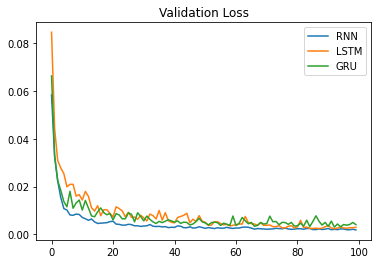

In [55]:
xx = np.arange(num_epochs)
plt.plot(xx, RNN_losses, label = 'RNN')
plt.plot(xx, LSTM_losses, label = 'LSTM')
plt.plot(xx, GRU_losses, label = 'GRU')
plt.legend()
plt.title('Validation Loss')
plt.show()

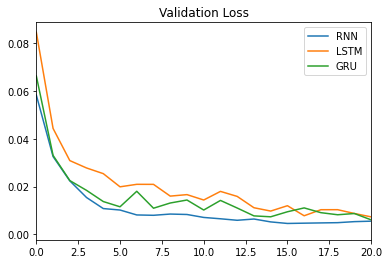

In [67]:
xx = np.arange(num_epochs)
plt.plot(xx, RNN_losses, label = 'RNN')
plt.plot(xx, LSTM_losses, label = 'LSTM')
plt.plot(xx, GRU_losses, label = 'GRU')
plt.legend()
plt.title('Validation Loss')
plt.xlim(0, 20)
plt.show()

The test losses for the RNN, LSTM, and GRU models are 0.0029, 0.0041, and 0.0042, respectively.

The main shortcoming of RNNs is their short-term memory problem, however in this particular problem, it does not seem to be detrimental.  When considering the data, this makes sense - the vast majority of the temperature swings are due to time of day, which is a 24 hour cycle.  RNNs are able to easily capture these temperature movements.  The seasonal temperature changes are on a 8,760 hour cycle, and the time series length is too small for even the LSTM and GRU models to effectively consider it.  With the specified window length, the seasonal temperature changes are nearly nonexistent, and as a result, the RNN did not perform worse than the LSTM and GRU models.  In fact, the RNN was notably more efficient in training and produced slightly better results than the other two models.  Ultimately, if there was more data and the window size was increased with it, the LSTM and GRU would likely outperform the RNN, however with this particular dataset and window size, the long-term memory is not needed for effective termperature prediction.

## Part 3
Using a traditional FFN to solve the same problem would result in a model that is not nearly as effective at predicting temperatures.  The main difference between the two models is that a FFN cannot account for time series data - it will not consider the order of the data sequences.  In this particular dataset, the previous temperatures have a significant impact on the next temperatures, and a FFN is not able to consider this.

There are some experimental techniques that can be applied to increase the efficacy of FFNs with time series data, but they tend to be not as effective and much more complex than their recurrent counterparts.  In this paper (http://www.karlbranting.net/papers/plummer/Paper_7_12_00.htm), Plummer describes a method of using wave transforms to decompose time series data into scales, which are then fed through a FFN.

# Task 2 - Word Embeddings
In this task, I am using the Glove 6B, 50 dimension word embeddings which can be downloaded here: https://nlp.stanford.edu/projects/glove/.

In [56]:
# store embeddings as dict
embeddings = {}
with open('glove.6B.50d.txt', 'r', encoding='cp437') as f:
	for row in f:
		vals = row.strip().split(' ')
		# the first value is the word, all the rest are embeddings
		embeddings[vals[0]] = np.array(vals[1:]).astype(np.float32)

In [57]:
def cosine_similarity(embeddings, w1, w2):
	# get embeddings for each word
	v1 = embeddings[w1]
	v2 = embeddings[w2]

	# calculate cosine similarity
	return (v1.dot(v2))/(np.linalg.norm(v1) * np.linalg.norm(v2))

The dissimilarity score I chose to use is Euclidean distance.  The further away two words are in the embedding space, the less similar they are, thus Euclidean distance emerges as a reasonable dissimilarity metric, where 0 is very similar and larger values represent increasingly less similar words.

In [58]:
def dissimilarity_metric(embeddings, w1, w2):
	# get embeddings for each word
	v1 = embeddings[w1]
	v2 = embeddings[w2]

	# calculate euclidean distance
	return np.linalg.norm(v1 - v2)

In [60]:
print(cosine_similarity(embeddings, "person", "spoon"))
print(dissimilarity_metric(embeddings, "person", "spoon"))

0.15182528
6.7810187


In [61]:
print(cosine_similarity(embeddings, "person", "people"))
print(dissimilarity_metric(embeddings, "person", "people"))

0.7322039
4.1152544


In [62]:
print(cosine_similarity(embeddings, "fork", "spoon"))
print(dissimilarity_metric(embeddings, "fork", "spoon"))

0.60393214
4.6915607


In [63]:
print(cosine_similarity(embeddings, "clock", "road"))
print(dissimilarity_metric(embeddings, "clock", "road"))

0.39802945
5.5096207


As shown by the examples above, similar words tend to have a lower Euclidean distance compared to dissimilar words.